In [7]:
import sys
sys.path.append('../00_Deliverable/')
from helper._paths import collectPaths
from helper._config_paths import path_root_videos

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, exists, isfile, getsize


from h_videos import *

In [8]:
# where to take videos from, where to save the images
from helper._config_paths import path_root_videos
root_imgs = '/home/dkhatanassia/PDM/img_from_videos'

# admitted channels
channels = [ch for ch in listdir(path_root_videos) 
            if not any(no in ch for no in ['#','.txt']) 
            and not isfile(ch)]

channels

['CH00000',
 'CH00001',
 'CH00004',
 'CH00005',
 'IN00001',
 'CH00006',
 '.DS_Store',
 'IN00002']

In [9]:
# print nb of videos and the cumulated size for each channel
for ch in channels:
    videos = collectPaths(join(path_root_videos,ch))
    if ch == 'CH00001': 
    print(f'{ch}: {len(videos)} files {int(sum([getsize(i)/(1024**3) for i in videos]))} GB')

CH00000: 8 files 0 GB
CH00001: 17859 files 5581 GB
CH00004: 3346 files 375 GB
CH00005: 197 files 15 GB
IN00001: 6505 files 1067 GB
CH00006: 0 files 0 GB
.DS_Store: 1 files 0 GB
IN00002: 1061 files 143 GB


In [14]:
# in a first phase, only extract from CH00004, contains jerrycan
channel = 'CH00004'
filters = videoFilters(channels=[channel],years=['2023'])
subset = filterVideos(videos,filters)

# check filtering
print(f'{channel}: {len(subset)} files {int(sum([getsize(i)/(1024**3) for i in subset]))} GB')

CH00004: 3346 files 375 GB


In [12]:
# extract images from videos listes in subset
if False:
    # info: total size to process
    total_size = int(sum([getsize(i)/(1024**3) for i in subset]))
    print(f'size to process: {total_size} GB')
    
    # start processing
    curr_size = 0
    for f in subset:
        #print(f'current file: {f}')
        extractImages(f)
        
        # info: processed data
        curr_size += getsize(f)/(1024**3)
        print(f'done {(curr_size/total_size):.2f}%')

## Filter result

In [13]:
import shutil
import random

'''def normalize(image):
    img = image.copy()
    img = img/255
    for i in range(3):
        tmp = img[:,:,i]
        tmp = (tmp-np.mean(tmp))/np.std(tmp)
        img[:,:,i] = tmp
    return img'''

# location of discarded images (moved from images)
backup_path = join(root_imgs,'00_backup')
makedirs(backup_path,exist_ok=True)

# pre-discreding location (copied from images)
control_path = join(root_imgs,'01_control')
makedirs(control_path,exist_ok=True)

# list all image location but those in control or backup
img_files = [join(root_imgs,im) for im in listdir(root_imgs) if not any(f in im for f in ['control','backup'])]
images = sorted(collectFiles(img_files))

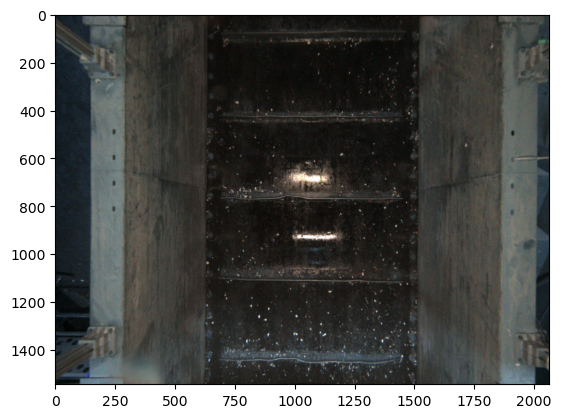

In [14]:
# bad img to remove and similar
rogue_id = 'CH00004_20230324_132941'
ref_img = [i for i in images if rogue_id in i][0]

plt_img = cv2.imread(ref_img)
plt.imshow(plt_img)

In [15]:
mses = []
for i in images:
    compare = cv2.imread(i)
    mses.append(mse(plt_img,compare))

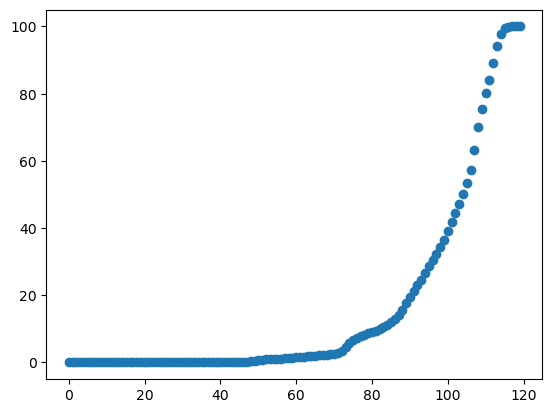

In [16]:
# plot % removed for several thresholds
masks_mse = [np.logical_and(np.array(mses)<th, np.array(mses)<th) for th in range(120)]
stats = [sum(mask)/len(mask)*100 for mask in masks_mse]

plt.scatter(np.arange(len(stats)), stats)

344


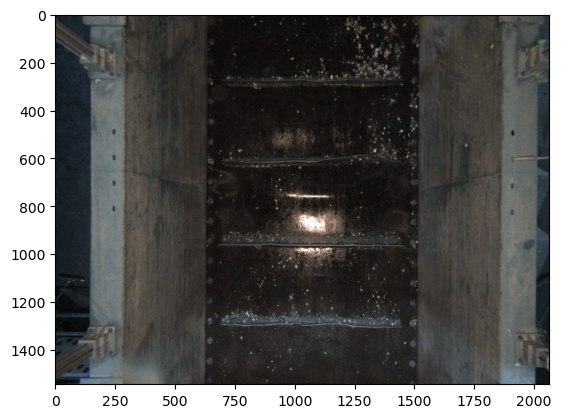

In [24]:
# pick meaningful threshold and check what it filters out
th = 60
mask_mse = np.array(mses)<th
to_be_removed = np.array(images)[mask_mse]

# plot random 
test = cv2.imread(to_be_removed[random.randint(0,sum(mask_mse)-1)])
plt.imshow(test)

# copy bad image candidates to control folder
[os.remove(join(control_path,j)) for j in listdir(control_path)]
for idx,i in enumerate(to_be_removed):
    shutil.copy(i,control_path)
print(idx)


In [25]:
# if control is satisfying
happy = True
if happy:
    for i in to_be_removed:
        # place bad image in backup (never completely delete them)
        shutil.move(i,backup_path)
    # empty control
    [os.remove(join(control_path,j)) for j in listdir(control_path)]